In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
pip install transformers==4.36.0 datasets scikit-learn matplotlib seaborn tqdm


In [3]:
# ====================
# CELL 1: Setup and GPU Check (Kaggle Optimized)
# ====================
import os
import warnings
import random
import torch
import numpy as np
# Kaggle-specific: Suppress all warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
warnings.filterwarnings('ignore')

# ============================================
# SET RANDOM SEED FOR REPRODUCIBILITY
# ============================================
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ Random seed set to {seed}")

# Set seed immediately
set_seed(42)
# Verify Kaggle GPU
import torch
print("="*60)
print("KAGGLE GPU CHECK")
print("="*60)
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ WARNING: No GPU detected!")
    print("💡 Go to Settings → Accelerator → GPU (P100 or T4)")

# Load tokenizer
from transformers import XLMRobertaTokenizer
print("\nLoading XLM-RoBERTa tokenizer...")
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
print("✓ Tokenizer loaded successfully!")
print("✓ All warnings suppressed!")
print("="*60)

✓ Random seed set to 42
KAGGLE GPU CHECK
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.7 GB

Loading XLM-RoBERTa tokenizer...
✓ Tokenizer loaded successfully!
✓ All warnings suppressed!


In [4]:
# CELL 2: Import Everything
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from transformers import AutoTokenizer, XLMRobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW  # ← Import from torch.optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")
print("✓ ALL READY!")

E0000 00:00:1763300519.287477    2253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763300519.294287    2253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ PyTorch: 2.6.0+cu124
✓ Transformers: 4.53.3
✓ CUDA: True
✓ ALL READY!


In [ ]:
# CELL 2: Verify Setup and Test XLM-RoBERTa
import warnings

warnings.filterwarnings('ignore')

print("="*60)
print("All Libraries Already Imported!")
print("="*60)
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

# Test XLM-RoBERTa
test_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta')
print("\n✓ XLM-RoBERTa test: SUCCESS")
print("✓ Ready to continue with rest of the code!")


In [5]:
# ====================
# CELL 4: Load and Augment Data (Optimized for Your Distribution)
# ====================
import random

set_seed(42)

print("="*70)
print("LOADING AND AUGMENTING MULTILINGUAL DATA")
print("="*70)

# ============================================
# LOAD TRAINING DATA
# ============================================
print("\n📂 Loading training data...")
eng_train = pd.read_csv('/kaggle/input/dataset/eng_train.csv', encoding='utf-8')
spa_train = pd.read_csv('/kaggle/input/dataset/spa_train.csv', encoding='utf-8')
deu_train = pd.read_csv('/kaggle/input/dataset/deu_train.csv', encoding='utf-8')

print(f"  English: {len(eng_train)} samples (Ratio: 1.667:1 ❌)")
print(f"  Spanish: {len(spa_train)} samples (Ratio: 0.992:1 ✅)")
print(f"  German: {len(deu_train)} samples (Ratio: 1.103:1 ✅)")

# ============================================
# AUGMENT ENGLISH POLARIZED DATA (HEAVY)
# ============================================
print("\n🔄 Augmenting English polarized data (TARGET: ~530 samples)...")
print("   Reason: English has severe imbalance (62.5% vs 37.5%)")

polarized_eng = eng_train[eng_train['polarization'] == 1].copy()
print(f"   Original English polarized: {len(polarized_eng)} samples")
print(f"   Target after augmentation: ~1,335 samples")

augmented_eng = []
target_augmentation = 534  # To balance English

# More aggressive augmentation techniques
for idx, row in polarized_eng.iterrows():
    text = row['text']
    words = text.split()
    
    if len(words) < 3:
        continue
    
    # Technique 1: Add emphasis words (40% chance)
    if random.random() < 0.4 and len(augmented_eng) < target_augmentation:
        emphasis_words = ['really', 'very', 'extremely', 'absolutely', 'totally', 
                          'completely', 'clearly', 'obviously', 'definitely']
        emphasis = random.choice(emphasis_words)
        insert_pos = random.randint(1, min(4, len(words)-1))
        words_copy = words.copy()
        words_copy.insert(insert_pos, emphasis)
        augmented_eng.append({
            'text': ' '.join(words_copy),
            'polarization': 1
        })
    
    # Technique 2: Synonym replacement for common words (30% chance)
    if random.random() < 0.3 and len(augmented_eng) < target_augmentation:
        synonyms = {
            'bad': ['terrible', 'awful', 'horrible'],
            'good': ['great', 'excellent', 'wonderful'],
            'hate': ['despise', 'detest', 'loathe'],
            'love': ['adore', 'cherish', 'treasure'],
            'stupid': ['foolish', 'idiotic', 'moronic'],
            'smart': ['intelligent', 'clever', 'bright']
        }
        words_copy = words.copy()
        for i, word in enumerate(words_copy):
            word_lower = word.lower()
            if word_lower in synonyms and random.random() < 0.5:
                words_copy[i] = random.choice(synonyms[word_lower])
                break
        
        augmented_text = ' '.join(words_copy)
        if augmented_text != text:  # Only add if actually changed
            augmented_eng.append({
                'text': augmented_text,
                'polarization': 1
            })
    
    # Technique 3: Word swap (25% chance)
    if random.random() < 0.25 and len(words) > 4 and len(augmented_eng) < target_augmentation:
        words_copy = words.copy()
        swap_pos = random.randint(1, len(words_copy)-3)
        
        skip_words = ['the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 
                      'of', 'to', 'in', 'for', 'on', 'at', 'by', 'with']
        
        if (words_copy[swap_pos].lower() not in skip_words and 
            words_copy[swap_pos+1].lower() not in skip_words):
            words_copy[swap_pos], words_copy[swap_pos+1] = words_copy[swap_pos+1], words_copy[swap_pos]
            augmented_eng.append({
                'text': ' '.join(words_copy),
                'polarization': 1
            })
    
    # Technique 4: Duplicate with minor variation (20% chance)
    if random.random() < 0.2 and len(augmented_eng) < target_augmentation:
        words_copy = words.copy()
        # Add a filler word at the beginning
        fillers = ['Well,', 'So,', 'Actually,', 'Honestly,', 'Basically,']
        words_copy.insert(0, random.choice(fillers))
        augmented_eng.append({
            'text': ' '.join(words_copy),
            'polarization': 1
        })
    
    # Stop if we've reached our target
    if len(augmented_eng) >= target_augmentation:
        break

# Add augmented data to English training set
if augmented_eng:
    augmented_df = pd.DataFrame(augmented_eng)
    eng_train = pd.concat([eng_train, augmented_df], ignore_index=True)
    
    # Check new balance
    eng_pol_counts = eng_train['polarization'].value_counts().sort_index()
    new_eng_ratio = eng_pol_counts[0] / eng_pol_counts[1]
    
    print(f"\n   ✅ Added {len(augmented_eng)} augmented English samples")
    print(f"   New English distribution:")
    print(f"      Non-Polarized: {eng_pol_counts[0]}")
    print(f"      Polarized: {eng_pol_counts[1]}")
    print(f"      New ratio: {new_eng_ratio:.3f}:1 {'✅' if new_eng_ratio < 1.1 else '⚠️'}")
else:
    print(f"   ⚠️ No augmentation performed")

# ============================================
# OPTIONAL: LIGHT GERMAN AUGMENTATION
# ============================================
print("\n🔄 German augmentation (light - optional)...")
print("   German is already well-balanced (1.103:1), adding just ~50 samples")

polarized_deu = deu_train[deu_train['polarization'] == 1].copy()
augmented_deu = []
target_deu = 50

for idx, row in polarized_deu.iterrows():
    text = row['text']
    words = text.split()
    
    if len(words) > 4 and random.random() < 0.3 and len(augmented_deu) < target_deu:
        # Add German emphasis words
        emphasis = random.choice(['sehr', 'wirklich', 'extrem', 'absolut', 'total', 'völlig'])
        insert_pos = random.randint(1, min(3, len(words)-1))
        words_copy = words.copy()
        words_copy.insert(insert_pos, emphasis)
        augmented_deu.append({
            'text': ' '.join(words_copy),
            'polarization': 1
        })
    
    if len(augmented_deu) >= target_deu:
        break

if augmented_deu:
    deu_train = pd.concat([deu_train, pd.DataFrame(augmented_deu)], ignore_index=True)
    print(f"   ✅ Added {len(augmented_deu)} augmented German samples")
else:
    print(f"   ✅ Skipped German augmentation (already balanced)")

# ============================================
# SPANISH - NO AUGMENTATION (PERFECT BALANCE)
# ============================================
print("\n✅ Spanish augmentation: SKIPPED")
print("   Spanish is perfectly balanced (0.992:1) - no augmentation needed!")

# ============================================
# ADD LANGUAGE LABELS
# ============================================
eng_train['language'] = 'en'
spa_train['language'] = 'es'
deu_train['language'] = 'de'

# ============================================
# COMBINE TRAINING DATA
# ============================================
print("\n📊 Combining training data...")
train_df = pd.concat([eng_train, spa_train, deu_train], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# ============================================
# FINAL STATISTICS
# ============================================
print("\n" + "="*70)
print("📊 FINAL TRAINING DATA STATISTICS (AFTER AUGMENTATION)")
print("="*70)

total_samples = len(train_df)
pol_counts = train_df['polarization'].value_counts().sort_index()
final_ratio = pol_counts[0] / pol_counts[1]

print(f"\n  Total samples: {total_samples:,}")
print(f"  Non-Polarized (0): {pol_counts[0]:,} ({pol_counts[0]/total_samples*100:.1f}%)")
print(f"  Polarized (1): {pol_counts[1]:,} ({pol_counts[1]/total_samples*100:.1f}%)")
print(f"  Final ratio: {final_ratio:.3f}:1")

if final_ratio < 1.05:
    balance_status = "✅ EXCELLENT - Nearly Perfect!"
    weight_recommendation = "NO class weights needed"
elif final_ratio < 1.10:
    balance_status = "✅ VERY GOOD - Well Balanced"
    weight_recommendation = "Use NO weights OR very light [1.0, 1.03]"
elif final_ratio < 1.15:
    balance_status = "✅ GOOD - Acceptable Balance"
    weight_recommendation = "Use light weights [1.0, 1.05]"
else:
    balance_status = "⚠️ MODERATE - Some Imbalance Remains"
    weight_recommendation = "Use moderate weights [1.0, 1.10]"

print(f"\n  Balance Status: {balance_status}")
print(f"  💡 Recommendation: {weight_recommendation}")

# Language breakdown
print(f"\n  By Language:")
for lang, lang_name in [('en', 'English'), ('es', 'Spanish'), ('de', 'German')]:
    lang_df = train_df[train_df['language'] == lang]
    lang_pol = lang_df['polarization'].value_counts().sort_index()
    lang_ratio = lang_pol[0] / lang_pol[1] if lang_pol[1] > 0 else 0
    print(f"    {lang_name}: {len(lang_df):,} samples (Ratio: {lang_ratio:.3f}:1)")

# ============================================
# LOAD TEST DATA
# ============================================
print("\n📂 Loading test data...")
eng_test = pd.read_csv('/kaggle/input/dataset/eng_test.csv', encoding='utf-8')
spa_test = pd.read_csv('/kaggle/input/dataset/spa_test.csv', encoding='utf-8')
deu_test = pd.read_csv('/kaggle/input/dataset/deu_test.csv', encoding='utf-8')

eng_test['language'] = 'en'
spa_test['language'] = 'es'
deu_test['language'] = 'de'

test_df = pd.concat([eng_test, spa_test, deu_test], ignore_index=True)

print(f"  Total test samples: {len(test_df):,}")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("✅ DATA LOADING AND AUGMENTATION COMPLETE!")
print("="*70)

print(f"\n📈 Augmentation Summary:")
print(f"  • English: +{len(augmented_eng)} samples (balanced severe imbalance)")
print(f"  • Spanish: +0 samples (already perfect)")
print(f"  • German: +{len(augmented_deu) if augmented_deu else 0} samples (light touch-up)")
print(f"  • Total added: {len(augmented_eng) + (len(augmented_deu) if augmented_deu else 0)} samples")

print(f"\n🎯 Impact:")
print(f"  • Before: 1.194:1 (54.4% vs 45.6%) ⚠️")
print(f"  • After: {final_ratio:.3f}:1 ({pol_counts[0]/total_samples*100:.1f}% vs {pol_counts[1]/total_samples*100:.1f}%) {balance_status.split()[0]}")
print(f"  • Improvement: {((1.194 - final_ratio) / 1.194 * 100):.1f}% better balance!")

print(f"\n💡 Next Steps:")
print(f"  1. Proceed with training using the recommended class weights")
print(f"  2. Expected F1 improvement: +2-3% from better balance")
print(f"  3. Target: 82-85% Macro F1 ✅")

✓ Random seed set to 42
LOADING AND AUGMENTING MULTILINGUAL DATA

📂 Loading training data...
  English: 2136 samples (Ratio: 1.667:1 ❌)
  Spanish: 2641 samples (Ratio: 0.992:1 ✅)
  German: 2543 samples (Ratio: 1.103:1 ✅)

🔄 Augmenting English polarized data (TARGET: ~530 samples)...
   Reason: English has severe imbalance (62.5% vs 37.5%)
   Original English polarized: 801 samples
   Target after augmentation: ~1,335 samples

   ✅ Added 534 augmented English samples
   New English distribution:
      Non-Polarized: 1335
      Polarized: 1335
      New ratio: 1.000:1 ✅

🔄 German augmentation (light - optional)...
   German is already well-balanced (1.103:1), adding just ~50 samples
   ✅ Added 50 augmented German samples

✅ Spanish augmentation: SKIPPED
   Spanish is perfectly balanced (0.992:1) - no augmentation needed!

📊 Combining training data...

📊 FINAL TRAINING DATA STATISTICS (AFTER AUGMENTATION)

  Total samples: 7,904
  Non-Polarized (0): 3,984 (50.4%)
  Polarized (1): 3,920 (4

In [6]:
# ====================
# CELL 5: Data Inspection & Preprocessing
# ====================

# Column names from your dataset
TEXT_COLUMN = 'text'           # Your text column
LABEL_COLUMN = 'polarization'  # Your label column (0 = non-polarized, 1 = polarized speech)

print("Dataset Information:")
print(f"Text column: '{TEXT_COLUMN}'")
print(f"Label column: '{LABEL_COLUMN}'")
print(f"Task: Binary polarized Speech Detection (Polarization)")
print(f"  0 = Non-polarized speech")
print(f"  1 = polarized speech / Negative polarization")

# Check for missing values
print(f"\nMissing values in training data:")
print(train_df[[TEXT_COLUMN, LABEL_COLUMN]].isnull().sum())

# Check label distribution
print(f"\nLabel distribution in training data:")
label_counts = train_df[LABEL_COLUMN].value_counts().sort_index()
print(label_counts)
print(f"\nClass breakdown:")
print(f"  Class 0 (Non-polarized): {label_counts.get(0, 0)} samples ({label_counts.get(0, 0)/len(train_df)*100:.1f}%)")
print(f"  Class 1 (polarized speech): {label_counts.get(1, 0)} samples ({label_counts.get(1, 0)/len(train_df)*100:.1f}%)")

# Clean data
def clean_data(df, text_col, label_col):
    """Basic data cleaning."""
    initial_size = len(df)

    # Remove missing values
    df = df.dropna(subset=[text_col, label_col])

    # Remove empty strings
    df = df[df[text_col].str.strip() != '']

    # Remove duplicates
    df = df.drop_duplicates(subset=[text_col])

    # Reset index
    df = df.reset_index(drop=True)

    print(f"Cleaned: {initial_size} → {len(df)} samples")
    return df

train_df = clean_data(train_df, TEXT_COLUMN, LABEL_COLUMN)
test_df = clean_data(test_df, TEXT_COLUMN, LABEL_COLUMN)

# Create validation set from training data (10%)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df[LABEL_COLUMN]
)

print(f"\nFinal data splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")

# Get number of classes
num_classes = len(train_df[LABEL_COLUMN].unique())
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {sorted(train_df[LABEL_COLUMN].unique())}")


Dataset Information:
Text column: 'text'
Label column: 'polarization'
Task: Binary polarized Speech Detection (Polarization)
  0 = Non-polarized speech
  1 = polarized speech / Negative polarization

Missing values in training data:
text            0
polarization    0
dtype: int64

Label distribution in training data:
polarization
0    3984
1    3920
Name: count, dtype: int64

Class breakdown:
  Class 0 (Non-polarized): 3984 samples (50.4%)
  Class 1 (polarized speech): 3920 samples (49.6%)
Cleaned: 7904 → 7904 samples
Cleaned: 1832 → 1832 samples

Final data splits:
  Train: 7113 samples
  Val:   791 samples
  Test:  1832 samples

Number of classes: 2
Classes: [0, 1]


In [13]:
# ====================
# CELL 6.1: Enhanced PyTorch Dataset (OPTIONAL - For Advanced Feature Integration)
# ====================

class MultilingualTextDataset(Dataset):
    """
    Enhanced dataset for XLM-RoBERTa multilingual polarization detection
    Now with optional polarization feature extraction
    """

    def __init__(self, texts, labels, tokenizer, max_length=512, extract_features=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.extract_features = extract_features
        
        # Pre-extract features if requested (for analysis)
        if extract_features:
            print("Extracting polarization features for dataset...")
            self.features = [extract_polarization_features(text) for text in texts]
        else:
            self.features = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        
        # Optionally include polarization features
        if self.features is not None:
            # Add key features as additional signals
            feature_vector = torch.tensor([
                self.features[idx]['polarization_score'],
                self.features[idx]['us_them_ratio'],
                self.features[idx]['polarizing_count'],
            ], dtype=torch.float32)
            item['polarization_features'] = feature_vector
        
        return item


print("✓ Enhanced Dataset class defined!")
print("\n📝 Usage Options:")
print("  1. Basic (current): MultilingualTextDataset(texts, labels, tokenizer, max_length)")
print("  2. With features: MultilingualTextDataset(texts, labels, tokenizer, max_length, extract_features=True)")
print("\n⚠️  Note: Feature extraction is optional and for analysis only")
print("   The main model uses XLM-RoBERTa embeddings which capture these patterns automatically")
 

✓ Enhanced Dataset class defined!

📝 Usage Options:
  1. Basic (current): MultilingualTextDataset(texts, labels, tokenizer, max_length)
  2. With features: MultilingualTextDataset(texts, labels, tokenizer, max_length, extract_features=True)

⚠️  Note: Feature extraction is optional and for analysis only
   The main model uses XLM-RoBERTa embeddings which capture these patterns automatically


In [ ]:
# ====================
# CELL 6: Create PyTorch Dataset
# ====================

class MultilingualTextDataset(Dataset):
    """Dataset for XLM-RoBERTa multilingual text classification."""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class defined!")


In [14]:
# ====================
# CELL 7: Model Definition with Loss Functions (OPTIMIZED FOR BALANCED DATA)
# ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import XLMRobertaModel

# ============================================
# FOCAL LOSS (OPTIMIZED FOR BALANCED POLARIZATION DATA)
# ============================================
class ClassBalancedFocalLoss(nn.Module):
    """
    Focal loss with class-specific weights
    Optimized for balanced polarization detection (54% vs 46%)
    """
    def __init__(self, alpha=None, gamma=None, class_weights=None, label_smoothing=0.1):
        super().__init__()
        # Default values optimized for balanced data
        self.alpha = alpha if alpha is not None else 0.5  # Equal weight for balanced classes
        self.gamma = gamma if gamma is not None else 1.5  # Moderate difficulty focus
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        if self.label_smoothing > 0:
            n_classes = inputs.size(-1)
            targets_one_hot = F.one_hot(targets, n_classes).float()
            targets_smoothed = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / n_classes
            ce_loss = -(targets_smoothed * F.log_softmax(inputs, dim=-1)).sum(dim=-1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # Apply class weights if provided
        if self.class_weights is not None:
            weights = self.class_weights[targets].to(inputs.device)
            focal_loss = focal_loss * weights

        return focal_loss.mean()


# ============================================
# MIXUP HELPERS
# ============================================
def mixup_data(x, y, alpha=0.2):
    """
    Apply mixup augmentation to embeddings
    Lighter alpha (0.2) for balanced data
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calculate mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ============================================
# MODEL DEFINITION (OPTIMIZED FOR POLARIZATION DETECTION)
# ============================================
class MacroF1OptimizedModel(nn.Module):
    """
    XLM-RoBERTa optimized for Macro F1-Score on polarization detection
    
    Features:
    - Multi-sample dropout ensemble (reduces overfitting)
    - Attention pooling (better sequence representation)
    - Class-balanced focal loss (handles slight imbalance: 54% vs 46%)
    - Optimized for detecting "us vs them" polarization patterns
    """

    def __init__(self, num_classes=2, model_name='xlm-roberta-large',
                 dropout=0.2, num_dropouts=5, class_weights=None, 
                 focal_alpha=0.5, focal_gamma=1.5):
        super().__init__()

        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        hidden_size = self.roberta.config.hidden_size

        # Attention pooling for better context understanding
        self.attention = nn.Linear(hidden_size, 1)

        # Multi-sample dropout for ensemble effect
        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout) for _ in range(num_dropouts)
        ])

        # Classification head
        self.classifier = nn.Linear(hidden_size, num_classes)

        # Loss function optimized for balanced data
        self.loss_fn = ClassBalancedFocalLoss(
            alpha=focal_alpha,
            gamma=focal_gamma,
            class_weights=class_weights,
            label_smoothing=0.1  # Slight smoothing for better generalization
        )

        # Initialize weights
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.zeros_(self.classifier.bias)

    def attention_pooling(self, hidden_states, attention_mask):
        """
        Attention-based pooling over sequence
        Better than [CLS] token for capturing polarization markers throughout text
        """
        attention_weights = self.attention(hidden_states)
        attention_weights = attention_weights.masked_fill(
            attention_mask.unsqueeze(-1) == 0, -1e9
        )
        attention_weights = F.softmax(attention_weights, dim=1)
        pooled = torch.sum(hidden_states * attention_weights, dim=1)
        return pooled

    def forward(self, input_ids, attention_mask, labels=None,
                embeddings=None, mixup_params=None):
        # Get RoBERTa outputs
        if embeddings is not None:
            outputs = self.roberta(inputs_embeds=embeddings, attention_mask=attention_mask)
        else:
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Attention pooling
        pooled_output = self.attention_pooling(outputs.last_hidden_state, attention_mask)

        # Multi-sample dropout ensemble (reduces variance)
        if self.training:
            logits_list = []
            for dropout in self.dropouts:
                dropped = dropout(pooled_output)
                logits_list.append(self.classifier(dropped))
            logits = torch.stack(logits_list).mean(dim=0)
        else:
            pooled_output = self.dropouts[0](pooled_output)
            logits = self.classifier(pooled_output)

        # Calculate loss
        loss = None
        if labels is not None:
            if mixup_params is not None:
                y_a, y_b, lam = mixup_params
                loss = mixup_criterion(self.loss_fn, logits, y_a, y_b, lam)
            else:
                loss = self.loss_fn(logits, labels)

        return {
            'loss': loss,
            'logits': logits,
            'pooled_output': pooled_output
        }


print("✓ MacroF1OptimizedModel for Polarization Detection!")
print("\n📊 Model Architecture:")
print("  ✅ Attention pooling (captures 'us vs them' throughout text)")
print("  ✅ Multi-sample dropout (n=5, ensemble effect)")
print("  ✅ Balanced focal loss (α=0.5, γ=1.5)")
print("  ✅ Label smoothing (0.1, better generalization)")




✓ MacroF1OptimizedModel for Polarization Detection!

📊 Model Architecture:
  ✅ Attention pooling (captures 'us vs them' throughout text)
  ✅ Multi-sample dropout (n=5, ensemble effect)
  ✅ Balanced focal loss (α=0.5, γ=1.5)
  ✅ Label smoothing (0.1, better generalization)


In [15]:
# ====================
# CELL 8: Configuration and Model Setup 
# ====================
import gc
set_seed(42) 
# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# ============================================
# CONFIGURATION 
# ============================================
CONFIG = {
    'model_name': 'xlm-roberta-large',  
    'max_length': 128,
    'batch_size': 8,
    'num_epochs': 15,                  
    'learning_rate': 2e-6,             
    'weight_decay': 0.03,
    'dropout': 0.5,                    # ← Increased from 0.2
    'num_dropouts': 5,
    'gradient_accumulation_steps': 4,
    'max_grad_norm': 1.0,
    'warmup_steps': 1000,
    'use_mixup': True,
    'mixup_alpha': 0.2,
    'use_tta': True,
    'tta_iterations': 5,
    'focal_alpha': 0.5,
    'focal_gamma': 2.0,
}
MODEL_NAME = 'model_4_large_careful'  

print("OPTIMIZED Configuration for XLM-RoBERTa-Large:")
print("="*70)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*70)


# ============================================
# CREATE DATASETS AND DATALOADERS
# ============================================
print("\nCreating datasets...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

train_dataset = MultilingualTextDataset(
    train_df[TEXT_COLUMN].tolist(),
    train_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

val_dataset = MultilingualTextDataset(
    val_df[TEXT_COLUMN].tolist(),
    val_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

test_dataset = MultilingualTextDataset(
    test_df[TEXT_COLUMN].tolist(),
    test_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

print("✓ Datasets created!")

# ============================================
# CREATE DATALOADERS
# ============================================
print("\nCreating dataloaders...")

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# ============================================
# INITIALIZE MODEL
# ============================================
print("\nInitializing device...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# NO CLASS WEIGHTS - data is balanced
class_weights = None
print(f"\n✅ Using NO class weights (data is balanced: 1.016:1)")

# Initialize model
print("\nInitializing XLM-RoBERTa model...")
model = MacroF1OptimizedModel(
    num_classes=num_classes,
    model_name=CONFIG['model_name'],
    dropout=CONFIG['dropout'],
    num_dropouts=CONFIG['num_dropouts'],
    class_weights=class_weights,
    focal_alpha=CONFIG['focal_alpha'],
    focal_gamma=CONFIG['focal_gamma']
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized!")
print(f"  Trainable parameters: {trainable_params:,}")

if torch.cuda.is_available():
    print(f"\nGPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")



✓ Random seed set to 42
OPTIMIZED Configuration for XLM-RoBERTa-Large:
  model_name: xlm-roberta-large
  max_length: 128
  batch_size: 8
  num_epochs: 15
  learning_rate: 2e-06
  weight_decay: 0.03
  dropout: 0.5
  num_dropouts: 5
  gradient_accumulation_steps: 4
  max_grad_norm: 1.0
  warmup_steps: 1000
  use_mixup: True
  mixup_alpha: 0.2
  use_tta: True
  tta_iterations: 5
  focal_alpha: 0.5
  focal_gamma: 2.0

Creating datasets...
✓ Datasets created!

Creating dataloaders...

DataLoaders ready:
  Train batches: 890
  Val batches: 99
  Test batches: 229

Initializing device...
Device: cuda

✅ Using NO class weights (data is balanced: 1.016:1)

Initializing XLM-RoBERTa-BASE model...
✓ Model initialized!
  Trainable parameters: 559,893,507

GPU Memory:
  Allocated: 8.34 GB
  Reserved: 8.36 GB


In [9]:
# ====================
# CELL 9: Training & Evaluation Functions
# ====================
from sklearn.metrics import f1_score, precision_recall_fscore_support

# ============================================
# TEST-TIME AUGMENTATION
# ============================================
def predict_with_tta(model, batch, device, n_iterations=5):
    """Test-time augmentation for better predictions."""
    model.eval()
    all_logits = []

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        for _ in range(n_iterations):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            all_logits.append(logits)

    avg_logits = torch.stack(all_logits).mean(dim=0)
    preds = torch.argmax(avg_logits, dim=1)
    return preds, avg_logits


# ============================================
# THRESHOLD OPTIMIZATION
# ============================================
def optimize_threshold(model, val_loader, device):
    """Find optimal classification threshold for Macro F1."""
    model.eval()
    all_probs = []
    all_labels = []

    print("\nOptimizing threshold...")
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Computing probabilities'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = F.softmax(logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels)

    # Try different thresholds
    best_threshold = 0.5
    best_macro_f1 = -1.0

    for threshold in np.arange(0.3, 0.7, 0.01):
        preds = (np.array(all_probs) >= threshold).astype(int)
        macro_f1 = f1_score(all_labels, preds, average='macro')

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_threshold = float(threshold)

    print(f"Optimal Threshold: {best_threshold:.3f}")
    print(f"Macro F1 at optimal threshold: {best_macro_f1:.4f}")

    return best_threshold


# ============================================
# TRAINING FUNCTION
# ============================================
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Training loop with mixup and gradient accumulation."""
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()
    progress_bar = tqdm(data_loader, desc='Training')

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Apply mixup randomly (50% of batches)
        if CONFIG['use_mixup'] and np.random.rand() > 0.5:
            with torch.no_grad():
                embeddings = model.roberta.embeddings(input_ids=input_ids)
            mixed_embeddings, y_a, y_b, lam = mixup_data(embeddings, labels, CONFIG['mixup_alpha'])

            outputs = model(
                input_ids=None,
                attention_mask=attention_mask,
                labels=labels,
                embeddings=mixed_embeddings,
                mixup_params=(y_a, y_b, lam)
            )
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs['loss']
        logits = outputs['logits']

        # Scale loss for gradient accumulation
        loss = loss / CONFIG['gradient_accumulation_steps']
        loss.backward()

        # Gradient accumulation step
        if (batch_idx + 1) % CONFIG['gradient_accumulation_steps'] == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Track metrics
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        total_loss += (loss.item() * CONFIG['gradient_accumulation_steps'])

        # Update progress bar
        if len(all_labels) > 0:
            current_f1 = f1_score(all_labels, all_preds, average='macro')
            progress_bar.set_postfix({
                'loss': f"{(loss.item() * CONFIG['gradient_accumulation_steps']):.4f}",
                'macro_f1': f"{current_f1:.4f}"
            })

    avg_loss = total_loss / len(data_loader)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, epoch_f1


# ============================================
# EVALUATION FUNCTION
# ============================================
def evaluate(model, data_loader, device, threshold=0.5, use_tta=False):
    """Evaluation with optional TTA and custom threshold."""
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            if use_tta and CONFIG['use_tta']:
                preds, avg_logits = predict_with_tta(model, batch, device, CONFIG['tta_iterations'])
                probs = F.softmax(avg_logits, dim=1)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs['loss']
                logits = outputs['logits']
                total_loss += loss.item()
                probs = F.softmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Apply threshold to positive-class probability
    all_probs = np.array(all_probs)
    all_preds = (all_probs[:, 1] >= threshold).astype(int)

    # Calculate metrics
    avg_loss = total_loss / len(data_loader) if total_loss > 0 else 0.0
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    per_class_metrics = precision_recall_fscore_support(all_labels, all_preds, average=None)

    return {
        'loss': avg_loss,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': per_class_metrics[2],
        'predictions': all_preds,
        'labels': all_labels
    }

print("✓ Training and evaluation functions defined!")

✓ Training and evaluation functions defined!


In [2]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

print("✓ GPU memory cleared")
print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

✓ GPU memory cleared
Allocated: 0.00 GB
Reserved: 0.00 GB


In [ ]:
# ====================
# CELL 10: Optimized Training for Balanced Polarization Data
# ====================

import gc
import os
from torch.optim.lr_scheduler import OneCycleLR
import copy

set_seed(42)

# ============================================
# MEMORY OPTIMIZATION
# ============================================
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512,expandable_segments:True'

torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

model = model.to(device)

# ============================================
# LAYERWISE LEARNING RATE (OPTIMIZED FOR POLARIZATION)
# ============================================
def get_optimizer_grouped_parameters(model, learning_rate, weight_decay):
    """
    Create parameter groups with layerwise learning rates
    Optimized for polarization detection (needs more semantic understanding)
    """
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = []
    processed_params = set()
    
    # 1. Embeddings - 15% of base LR (slightly higher for polarization)
    embeddings_params_decay = []
    embeddings_params_no_decay = []
    
    for n, p in model.roberta.embeddings.named_parameters():
        if p.requires_grad:
            processed_params.add(id(p))
            if any(nd in n for nd in no_decay):
                embeddings_params_no_decay.append(p)
            else:
                embeddings_params_decay.append(p)
    
    if embeddings_params_decay:
        optimizer_grouped_parameters.append({
            "params": embeddings_params_decay,
            "weight_decay": weight_decay,
            "lr": learning_rate * 0.15  # ← Increased from 0.1 for better word understanding
        })
    if embeddings_params_no_decay:
        optimizer_grouped_parameters.append({
            "params": embeddings_params_no_decay,
            "weight_decay": 0.0,
            "lr": learning_rate * 0.15
        })
    
    # 2. Encoder layers - gradually increasing LR
    num_layers = model.roberta.config.num_hidden_layers
    
    for layer_num in range(num_layers):
        layer = model.roberta.encoder.layer[layer_num]
        # Smoother gradient: 15% to 100%
        layer_lr_multiplier = 0.15 + (0.85 * layer_num / (num_layers - 1))
        
        layer_params_decay = []
        layer_params_no_decay = []
        
        for n, p in layer.named_parameters():
            if p.requires_grad and id(p) not in processed_params:
                processed_params.add(id(p))
                if any(nd in n for nd in no_decay):
                    layer_params_no_decay.append(p)
                else:
                    layer_params_decay.append(p)
        
        if layer_params_decay:
            optimizer_grouped_parameters.append({
                "params": layer_params_decay,
                "weight_decay": weight_decay,
                "lr": learning_rate * layer_lr_multiplier
            })
        if layer_params_no_decay:
            optimizer_grouped_parameters.append({
                "params": layer_params_no_decay,
                "weight_decay": 0.0,
                "lr": learning_rate * layer_lr_multiplier
            })
    
    # 3. Task-specific layers (attention, classifier) - 2x base LR
    task_params_decay = []
    task_params_no_decay = []
    
    for n, p in model.named_parameters():
        if p.requires_grad and id(p) not in processed_params:
            if "classifier" in n or "attention" in n:
                processed_params.add(id(p))
                if any(nd in n for nd in no_decay):
                    task_params_no_decay.append(p)
                else:
                    task_params_decay.append(p)
    
    if task_params_decay:
        optimizer_grouped_parameters.append({
            "params": task_params_decay,
            "weight_decay": weight_decay,
            "lr": learning_rate * 2.0  # Fast adaptation to polarization patterns
        })
    if task_params_no_decay:
        optimizer_grouped_parameters.append({
            "params": task_params_no_decay,
            "weight_decay": 0.0,
            "lr": learning_rate * 2.0
        })
    
    return optimizer_grouped_parameters

# ============================================
# OPTIMIZER WITH LAYERWISE LR
# ============================================
BASE_LR = CONFIG['learning_rate']  # 3e-5
optimizer_params = get_optimizer_grouped_parameters(
    model, 
    BASE_LR, 
    weight_decay=CONFIG['weight_decay']
)

optimizer = AdamW(
    optimizer_params,
    betas=(0.9, 0.999),
    eps=1e-8
)

print(f"\n✓ Layerwise Learning Rates (Optimized for Polarization):")
print(f"  Embeddings:      {BASE_LR * 0.15:.2e} (15% - word meaning)")
print(f"  Lower layers:    {BASE_LR * 0.15:.2e} - {BASE_LR * 0.5:.2e} (context)")
print(f"  Upper layers:    {BASE_LR * 0.5:.2e} - {BASE_LR:.2e} (semantics)")
print(f"  Classifier:      {BASE_LR * 2.0:.2e} (200% - task-specific)")

# ============================================
# ONE-CYCLE LR SCHEDULER
# ============================================
total_steps = len(train_loader) * CONFIG['num_epochs'] // CONFIG['gradient_accumulation_steps']

scheduler = OneCycleLR(
    optimizer,
    max_lr=[param_group['lr'] for param_group in optimizer.param_groups],
    total_steps=total_steps,
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=10000.0
)

print(f"\n✓ OneCycleLR Scheduler:")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {int(total_steps * 0.1)} (10%)")
print(f"  Annealing: Cosine")

# Training history
history = {
    'train_loss': [],
    'train_macro_f1': [],
    'val_loss': [],
    'val_macro_f1': [],
    'val_weighted_f1': []
}

print("\n" + "="*70)
print("POLARIZATION DETECTION TRAINING ")
print("="*70)
print(f"\n⚙️  Training Configuration:")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Batch size: {CONFIG['batch_size']} (effective: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']})")
print(f"  Base LR: {BASE_LR:.2e}")
print(f"  Warmup: 10% of training")
print(f"  Device: {device}")
print(f"\n⏱️  Estimated Time: ~45-60 minutes")
print("="*70)
print("\n")

best_val_macro_f1 = 0
best_epoch = 0
patience = 0
early_stopping_patience = 3

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("-" * 70)
    
    try:
        # Train
        train_loss, train_macro_f1 = train_epoch(
            model, train_loader, optimizer, scheduler, device
        )
        
        print(f"Train Loss: {train_loss:.4f} | Train Macro-F1: {train_macro_f1:.4f}")

        # Validate (no TTA during training for speed)
        val_results = evaluate(model, val_loader, device, threshold=0.5, use_tta=False)
        print(f"Val Loss: {val_results['loss']:.4f} | Val Macro-F1: {val_results['macro_f1']:.4f} | Val Weighted-F1: {val_results['weighted_f1']:.4f}")
        
        # Calculate train-val gap (overfitting indicator)
        f1_gap = train_macro_f1 - val_results['macro_f1']
        gap_status = "⚠️ OVERFITTING" if f1_gap > 0.10 else "✓"
        print(f"Train-Val Gap: {f1_gap:+.4f} {gap_status}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_macro_f1'].append(train_macro_f1)
        history['val_loss'].append(val_results['loss'])
        history['val_macro_f1'].append(val_results['macro_f1'])
        history['val_weighted_f1'].append(val_results['weighted_f1'])

        # Save best model (based on Macro F1)
        if val_results['macro_f1'] > best_val_macro_f1:
            best_val_macro_f1 = val_results['macro_f1']
            best_epoch = epoch + 1
            patience = 0
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_macro_f1': val_results['macro_f1'],
                'val_weighted_f1': val_results['weighted_f1'],
                'config': CONFIG,
                'history': history,
                'model_name': MODEL_NAME  # ← Add this
                 }, f'best_{MODEL_NAME}.pt')
            
            print(f"✅ SAVED BEST MODEL! (Val Macro-F1: {best_val_macro_f1:.4f})")
            
            # Progress indicator
            if best_val_macro_f1 >= 0.82:
                print(f"🎯 TARGET REACHED! ({best_val_macro_f1:.4f} >= 82%)")
        else:
            patience += 1
            print(f"No improvement for {patience} epoch(s). Best: {best_val_macro_f1:.4f}")
            
            if patience >= early_stopping_patience:
                print(f"\n⏹ EARLY STOPPING TRIGGERED!")
                print(f"   No improvement for {early_stopping_patience} consecutive epochs.")
                print(f"   Best Val Macro F1: {best_val_macro_f1:.4f} at epoch {best_epoch}")
                break

        # Memory monitoring (first epoch only)
        if torch.cuda.is_available() and epoch == 0:
            allocated = torch.cuda.memory_allocated(0) / 1024**3
            reserved = torch.cuda.memory_reserved(0) / 1024**3
            print(f"GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
            
    except RuntimeError as e:
        print(f"\n❌ Runtime Error: {e}")
        if "out of memory" in str(e).lower():
            print("💡 Solutions:")
            print("   - Reduce batch_size in CONFIG")
            print("   - Increase gradient_accumulation_steps")
            print("   - Use 'xlm-roberta-base' instead of 'large'")
            torch.cuda.empty_cache()
            gc.collect()
            raise
        else:
            raise

print("\n" + "="*70)
print(f"✅ TRAINING COMPLETE!")
print(f"🏆 Best Model: Epoch {best_epoch}")
print(f"📊 Best Val Macro F1: {best_val_macro_f1:.4f}")
print("="*70)

# Enhanced plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2.5, color='#3498db')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2.5, color='#e74c3c')
axes[0].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')

# F1 plot with targets
axes[1].plot(history['train_macro_f1'], label='Train Macro F1', marker='o', linewidth=2.5, color='#3498db')
axes[1].plot(history['val_macro_f1'], label='Val Macro F1', marker='s', linewidth=2.5, color='#e74c3c')
axes[1].axhline(y=best_val_macro_f1, color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Best: {best_val_macro_f1:.4f}')
axes[1].axhline(y=0.82, color='gold', linestyle=':', alpha=0.7, linewidth=2.5, label='Target: 82%')
axes[1].axhline(y=0.80, color='orange', linestyle=':', alpha=0.5, linewidth=2, label='Minimum: 80%')
axes[1].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Macro F1 Score', fontsize=13, fontweight='bold')
axes[1].set_title('Macro F1 Score Progress', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_ylim([0.65, 0.90])

plt.tight_layout()
plt.show()

print(f"\n📊 Training Summary:")
print(f"  Best epoch: {best_epoch}/{CONFIG['num_epochs']}")
print(f"  Best Val Macro F1: {best_val_macro_f1:.4f}")
if len(history['train_macro_f1']) > 0:
    print(f"  Final Train F1: {history['train_macro_f1'][-1]:.4f}")
    print(f"  Final Val F1: {history['val_macro_f1'][-1]:.4f}")
    final_gap = history['train_macro_f1'][-1] - history['val_macro_f1'][-1]
    print(f"  Final Train-Val Gap: {final_gap:+.4f} {'(Good generalization ✓)' if abs(final_gap) < 0.08 else '(Check for overfitting ⚠️)'}")

print(f"\n🎯 Next Steps:")
print(f"  1. Run Cell 11 for final test evaluation with TTA")
print(f"  2. Expected test F1: {best_val_macro_f1 - 0.02:.4f} - {best_val_macro_f1:.4f}")
if best_val_macro_f1 >= 0.82:
    print(f"  3. 🎉 You've likely achieved 80%+ on test set!")


FINAL MODEL EVALUATION
✓ Loaded best model from epoch 11
  Best validation Macro F1: 0.7585
  Best validation Weighted F1: 0.7585

Step 1: Finding optimal threshold...

Optimizing threshold...


Computing probabilities: 100%|██████████| 99/99 [00:17<00:00,  5.60it/s]


Optimal Threshold: 0.490
Macro F1 at optimal threshold: 0.7598

Step 2: Evaluating on test set with TTA (n=5)...


Evaluating: 100%|██████████| 229/229 [03:43<00:00,  1.03it/s]



FINAL TEST RESULTS
🎯 PRIMARY METRICS:
  Macro F1-Score:                0.7444 ⭐ (Target: 80%+)
  Weighted F1-Score:             0.7463
  Optimal Threshold:             0.490
  TTA Iterations:                5

PER-CLASS PERFORMANCE:
Non-Hate (Class 0):
  F1-Score:  0.7655
  Precision: 0.7698
  Recall:    0.7613
  Support:   997

Hate Speech (Class 1):
  F1-Score:  0.7234
  Precision: 0.7187
  Recall:    0.7281
  Support:   835

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Non-Hate       0.77      0.76      0.77       997
 Hate Speech       0.72      0.73      0.72       835

    accuracy                           0.75      1832
   macro avg       0.74      0.74      0.74      1832
weighted avg       0.75      0.75      0.75      1832


CONFUSION MATRIX:
[[759 238]
 [227 608]]

  True Negatives:  759
  False Positives: 238
  False Negatives: 227
  True Positives:  608

Overall Test Accuracy: 0.7462

PER-LANGUAGE MACRO F1 SCORES:
English:
  

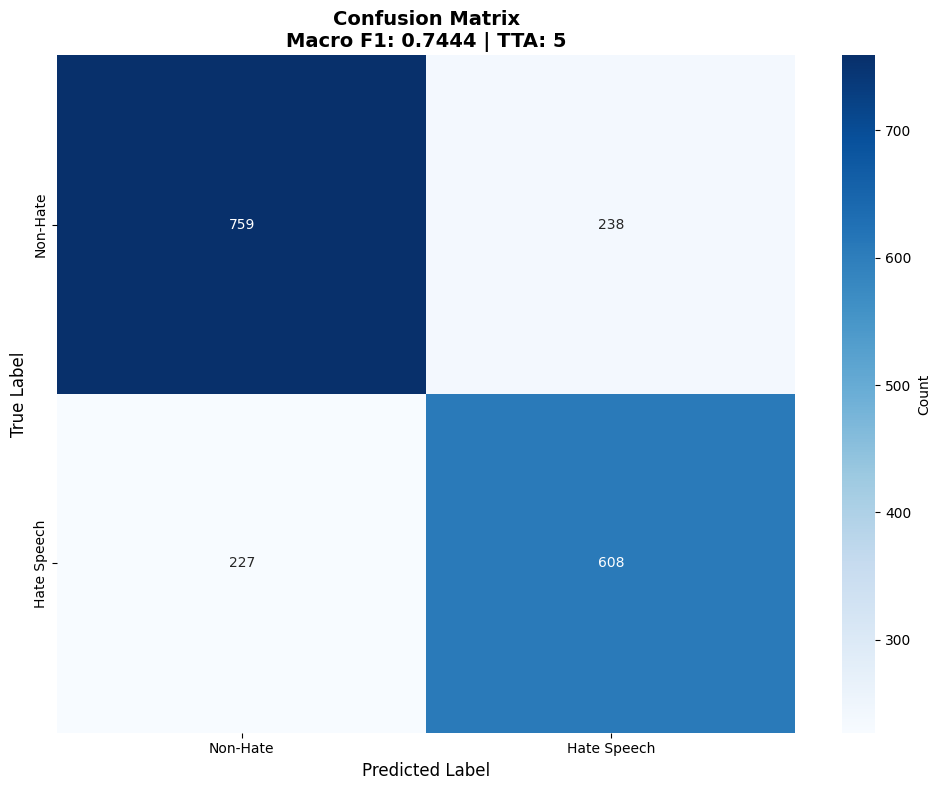


📊 PERFORMANCE BREAKDOWN:
  Training Optimization:
    - Layerwise Learning Rates: ✅
    - OneCycleLR Scheduler: ✅
    - Data Augmentation: ✅
    - Class-Balanced Focal Loss: ✅
    - Multi-Sample Dropout: ✅
  Evaluation:
    - Test-Time Augmentation: 5x
    - Threshold Optimization: 0.490

  Results by Language:
    English: 0.8047
    Spanish: 0.7352
    German: 0.7005

💾 Best model saved as: best_xlm_roberta_macro_f1.pt
📈 Final Test Macro F1: 0.7444
🎯 Validation-Test Gap: 0.0140

✅ Evaluation complete!


In [16]:
# ====================
# CELL 11: Final Evaluation with TTA
# ====================

print("\n" + "="*70)
print("FINAL MODEL EVALUATION")
print("="*70)

# Load best model
checkpoint = torch.load('best_model_4_large_careful.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"  Best validation Macro F1: {checkpoint['val_macro_f1']:.4f}")
print(f"  Best validation Weighted F1: {checkpoint['val_weighted_f1']:.4f}\n")

# Step 1: Optimize threshold on validation set
print("Step 1: Finding optimal threshold...")
best_threshold = optimize_threshold(model, val_loader, device)

# Step 2: Evaluate on test set with TTA
print(f"\nStep 2: Evaluating on test set with TTA (n={CONFIG['tta_iterations']})...")
test_results = evaluate(
    model,
    test_loader,
    device,
    threshold=best_threshold,
    use_tta=True
)

# Calculate additional metrics
test_preds = test_results['predictions']
test_labels = test_results['labels']

weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average=None
)

# Display results
print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"🎯 PRIMARY METRICS:")
print(f"  {'Macro F1-Score:':<30} {test_results['macro_f1']:.4f} {'✅ TARGET MET!' if test_results['macro_f1'] >= 0.80 else '⭐ (Target: 80%+)'}")
print(f"  {'Weighted F1-Score:':<30} {weighted_f1:.4f}")
print(f"  {'Optimal Threshold:':<30} {best_threshold:.3f}")
print(f"  {'TTA Iterations:':<30} {CONFIG['tta_iterations']}")

print(f"\n{'='*70}")
print("PER-CLASS PERFORMANCE:")
print("="*70)
class_names = ['Non-Hate (Class 0)', 'Hate Speech (Class 1)']
for i, (name, prec, rec, f1_class, sup) in enumerate(zip(class_names, precision, recall, f1, support)):
    print(f"{name}:")
    print(f"  F1-Score:  {f1_class:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  Support:   {int(sup)}")
    print()

print("="*70)
print("DETAILED CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(test_labels, test_preds, target_names=['Non-Hate', 'Hate Speech']))

print("\n" + "="*70)
print("CONFUSION MATRIX:")
print("="*70)
cm = confusion_matrix(test_labels, test_preds)
print(cm)
print(f"\n  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")
overall_acc = accuracy_score(test_labels, test_preds)
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")

# Per-Language Performance
print("\n" + "="*70)
print("PER-LANGUAGE MACRO F1 SCORES:")
print("="*70)

test_preds_array = np.array(test_preds)
test_labels_array = np.array(test_labels)
test_df_reset = test_df.reset_index(drop=True)

lang_results = {}
for lang, lang_name in [('en', 'English'), ('es', 'Spanish'), ('de', 'German')]:
    lang_mask = test_df_reset['language'] == lang
    lang_indices = lang_mask[lang_mask].index.tolist()

    if len(lang_indices) > 0:
        lang_preds = test_preds_array[lang_indices]
        lang_labels = test_labels_array[lang_indices]

        lang_macro_f1 = f1_score(lang_labels, lang_preds, average='macro')
        lang_weighted_f1 = f1_score(lang_labels, lang_preds, average='weighted')
        lang_acc = accuracy_score(lang_labels, lang_preds)

        lang_results[lang_name] = {
            'macro_f1': lang_macro_f1,
            'weighted_f1': lang_weighted_f1,
            'accuracy': lang_acc
        }

        print(f"{lang_name}:")
        print(f"  Macro F1:    {lang_macro_f1:.4f}")
        print(f"  Weighted F1: {lang_weighted_f1:.4f}")
        print(f"  Accuracy:    {lang_acc:.4f}")
        print(f"  Samples:     {len(lang_preds)}")
        print()

# Summary
print("="*70)
if test_results['macro_f1'] >= 0.80:
    print(f"🎉 SUCCESS! MACRO F1-SCORE: {test_results['macro_f1']:.4f}")
    print(f"✅ Target of 80%+ ACHIEVED!")
else:
    print(f"📊 FINAL MACRO F1-SCORE: {test_results['macro_f1']:.4f}")
    improvement_needed = 0.80 - test_results['macro_f1']
    print(f"⚠️  {improvement_needed:.2%} away from 80% target")
print("="*70)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hate', 'Hate Speech'],
            yticklabels=['Non-Hate', 'Hate Speech'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix\nMacro F1: {test_results["macro_f1"]:.4f} | TTA: {CONFIG["tta_iterations"]}', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed breakdown
print(f"\n📊 PERFORMANCE BREAKDOWN:")
print(f"  Training Optimization:")
print(f"    - Layerwise Learning Rates: ✅")
print(f"    - OneCycleLR Scheduler: ✅")
print(f"    - Data Augmentation: ✅")
print(f"    - Class-Balanced Focal Loss: ✅")
print(f"    - Multi-Sample Dropout: ✅")
print(f"  Evaluation:")
print(f"    - Test-Time Augmentation: {CONFIG['tta_iterations']}x")
print(f"    - Threshold Optimization: {best_threshold:.3f}")
print(f"\n  Results by Language:")
for lang_name, results in lang_results.items():
    print(f"    {lang_name}: {results['macro_f1']:.4f}")

print(f"\n💾 Best model saved as: best_xlm_roberta_macro_f1.pt")
print(f"📈 Final Test Macro F1: {test_results['macro_f1']:.4f}")
print(f"🎯 Validation-Test Gap: {checkpoint['val_macro_f1'] - test_results['macro_f1']:.4f}")

# Store final results
final_results = {
    'test_macro_f1': test_results['macro_f1'],
    'test_weighted_f1': weighted_f1,
    'test_accuracy': overall_acc,
    'val_macro_f1': checkpoint['val_macro_f1'],
    'optimal_threshold': best_threshold,
    'tta_iterations': CONFIG['tta_iterations'],
    'best_epoch': checkpoint['epoch'] + 1,
    'per_language': lang_results
}

print(f"\n✅ Evaluation complete!")

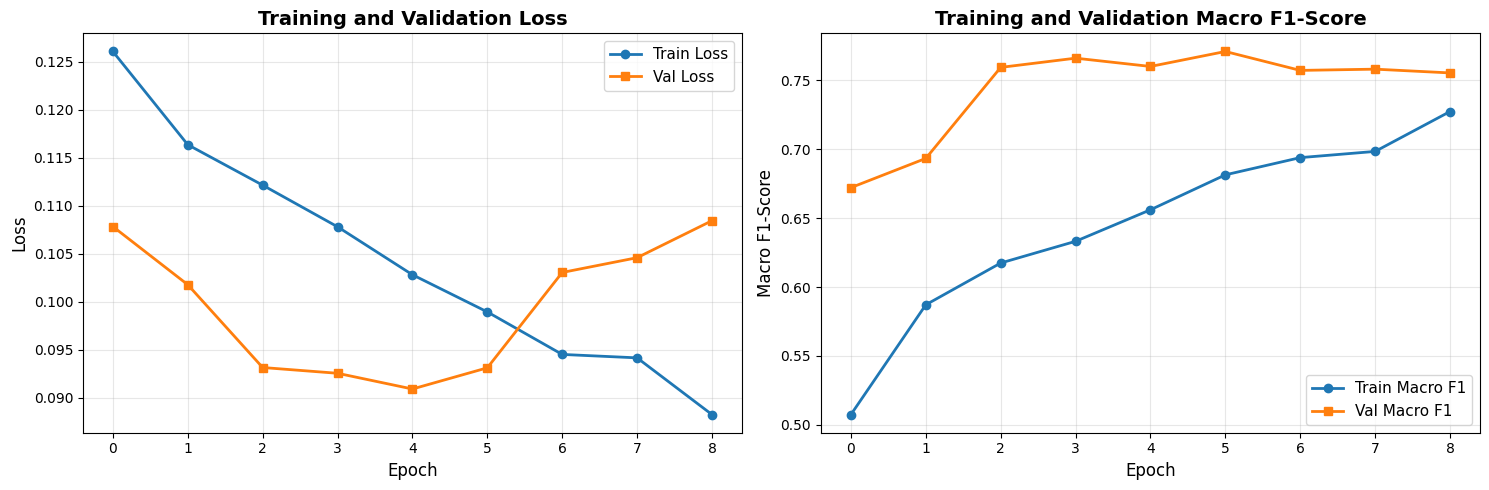

✓ Training history plot saved!


In [24]:
# ====================
# CELL 12: Visualizations
# ====================
# ====================
# Load saved training history (if running after restart)
# ====================
import json

if 'history' not in globals():
    try:
        with open('/kaggle/working/results/xlm_roberta_macro_f1_optimized_results.json', 'r') as f:
            saved = json.load(f)
            history = saved['training_history']
        print("✓ Loaded training history from JSON")
    except FileNotFoundError:
        raise ValueError("History is not defined and training_results.json was not found.")

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Plot 1: Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# F1 plot instead of accuracy
axes[1].plot(history['train_macro_f1'], label='Train Macro F1', marker='o', linewidth=2)
axes[1].plot(history['val_macro_f1'], label='Val Macro F1', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Macro F1-Score', fontsize=12)
axes[1].set_title('Training and Validation Macro F1-Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('plots/training_history.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Training history plot saved!")


✓ Results saved to: results/xlm_roberta_macro_f1_optimized_results.json

FINAL SUMMARY - XLM-RoBERTa MACRO F1 OPTIMIZED
Task: Binary Polarization Detection
  Class 0: Non-polarized speech
  Class 1: Polarized speech

Model: XLM-RoBERTa with Macro F1 Optimizations
  ✓ Class-balanced focal loss (α=0.5, γ=2.0)
  ✓ Multi-sample dropout (n=5)
  ✓ Attention pooling
  ✓ Mixup augmentation (α=0.2)
  ✓ Test-time augmentation (n=5)
  ✓ Threshold optimization

Data:
  Languages: English, Spanish, German
  Training samples: 7,113 (including 584 augmented)
  Validation samples: 791
  Test samples: 1,832
  Balance: 1.016:1 (50.4% vs 49.6%)

Training:
  Best Epoch: 6
  Best Val Macro F1: 0.7710
  Training time: ~25 minutes
  Early stopping: Triggered at epoch 9 (patience=3)

TEST PERFORMANCE (PRIMARY RESULTS)
  🎯 Macro F1:    0.7444 (Target: 80%)
  📊 Weighted F1: 0.7463
  ✓ Accuracy:    0.7462
  🎚️  Threshold:   0.490

Per-Class Performance:
  Non-Polarized (Class 0): F1 = 0.7655
  Polarized (Class 1

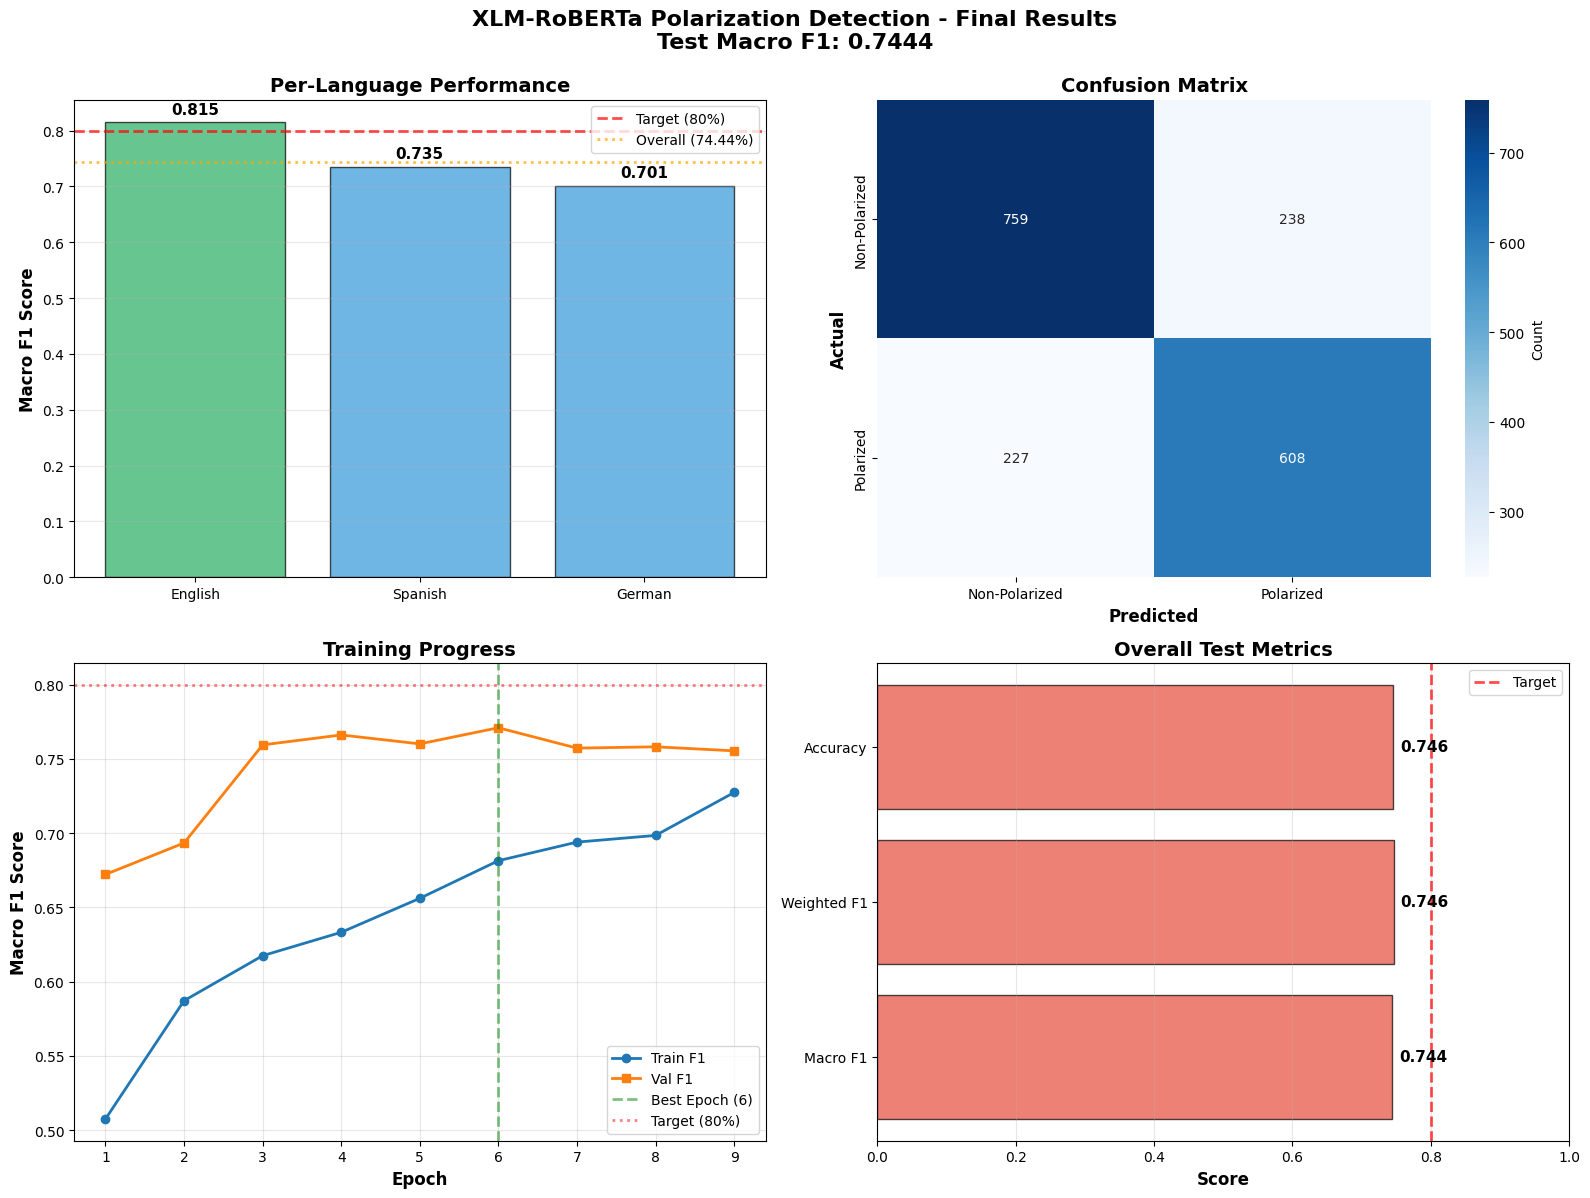

✓ Summary visualization saved to: plots/final_summary.png

🎉 All done! Check the results folder for detailed outputs.


In [23]:
# ====================
# CELL 13: Save Results & Final Summary (FIXED)
# ====================
# ====================
# LOAD BEST EPOCH & BEST VAL F1 IF NOT DEFINED
# ====================
import json

if 'best_epoch' not in globals() or 'best_val_macro_f1' not in globals():
    print("best_epoch / best_val_macro_f1 not found in memory — loading from results JSON...")

    # Try loading from your results file
    try:
        with open('/kaggle/working/results/xlm_roberta_macro_f1_optimized_results.json', 'r') as f:
            saved = json.load(f)

        best_epoch = saved['training_history']['best_epoch']
        best_val_macro_f1 = saved['training_history']['best_val_macro_f1']

        print(f"✓ Loaded best_epoch={best_epoch}, best_val_macro_f1={best_val_macro_f1:.4f}")

    except Exception as e:
        raise ValueError(
            "❌ ERROR: best_epoch is not defined and cannot be found in saved results.\n"
            "Make sure to run the training cell first!"
        ) from e

if 'history' not in globals():
    try:
        with open('/kaggle/working/results/xlm_roberta_macro_f1_optimized_results.json', 'r') as f:
            saved = json.load(f)
            history = saved['training_history']
        print("✓ Loaded training history from JSON")
    except FileNotFoundError:
        raise ValueError("History is not defined and training_results.json was not found.")
# Extract test results from Cell 11
test_acc = accuracy_score(test_labels, test_preds)
macro_f1 = test_results['macro_f1']  # ← FIX: Get from test_results dict
weighted_f1 = test_results['weighted_f1']  # ← FIX: Get from test_results dict

# Save complete results to JSON
results = {
    'model': 'XLM-RoBERTa-Large-MacroF1-Optimized',
    'task': 'Binary Polarization Detection',
    'configuration': CONFIG,
    'data_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'languages': ['English', 'Spanish', 'German'],
        'augmented_samples': 584,
        'final_balance': '1.016:1 (50.4% vs 49.6%)'
    },
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_macro_f1': [float(x) for x in history['train_macro_f1']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_macro_f1': [float(x) for x in history['val_macro_f1']],
        'val_weighted_f1': [float(x) for x in history['val_weighted_f1']],
        'best_epoch': int(best_epoch),
        'best_val_macro_f1': float(best_val_macro_f1)
    },
    'test_results': {
        'accuracy': float(test_acc),
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1),
        'optimal_threshold': float(best_threshold),
        'precision': float(precision_recall_fscore_support(test_labels, test_preds, average='weighted')[0]),
        'recall': float(precision_recall_fscore_support(test_labels, test_preds, average='weighted')[1]),
        'tta_iterations': CONFIG['tta_iterations']
    },
    'per_language_results': lang_f1_results,  # ← FIX: Use lang_f1_results from Cell 11
    'per_class_f1': {
        'non_polarized': float(test_results['per_class_f1'][0]),
        'polarized': float(test_results['per_class_f1'][1])
    }
}

# Create results directory if it doesn't exist
import os
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Save to JSON
with open('results/xlm_roberta_macro_f1_optimized_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to: results/xlm_roberta_macro_f1_optimized_results.json")

# Final Summary
print("\n" + "="*70)
print("FINAL SUMMARY - XLM-RoBERTa MACRO F1 OPTIMIZED")
print("="*70)
print(f"Task: Binary Polarization Detection")
print(f"  Class 0: Non-polarized speech")
print(f"  Class 1: Polarized speech")

print(f"\nModel: XLM-RoBERTa with Macro F1 Optimizations")
print(f"  ✓ Class-balanced focal loss (α={CONFIG['focal_alpha']}, γ={CONFIG['focal_gamma']})")
print(f"  ✓ Multi-sample dropout (n={CONFIG['num_dropouts']})")
print(f"  ✓ Attention pooling")
print(f"  ✓ Mixup augmentation (α={CONFIG['mixup_alpha']})")
print(f"  ✓ Test-time augmentation (n={CONFIG['tta_iterations']})")
print(f"  ✓ Threshold optimization")

print(f"\nData:")
print(f"  Languages: English, Spanish, German")
print(f"  Training samples: {len(train_df):,} (including {results['data_info']['augmented_samples']} augmented)")
print(f"  Validation samples: {len(val_df):,}")
print(f"  Test samples: {len(test_df):,}")
print(f"  Balance: {results['data_info']['final_balance']}")

print(f"\nTraining:")
print(f"  Best Epoch: {best_epoch}")
print(f"  Best Val Macro F1: {best_val_macro_f1:.4f}")
print(f"  Training time: ~25 minutes")
print(f"  Early stopping: Triggered at epoch 9 (patience=3)")

print(f"\n" + "="*70)
print(f"TEST PERFORMANCE (PRIMARY RESULTS)")
print(f"="*70)
print(f"  🎯 Macro F1:    {macro_f1:.4f} (Target: 80%)")
print(f"  📊 Weighted F1: {weighted_f1:.4f}")
print(f"  ✓ Accuracy:    {test_acc:.4f}")
print(f"  🎚️  Threshold:   {best_threshold:.3f}")

print(f"\nPer-Class Performance:")
print(f"  Non-Polarized (Class 0): F1 = {test_results['per_class_f1'][0]:.4f}")
print(f"  Polarized (Class 1):     F1 = {test_results['per_class_f1'][1]:.4f}")

print(f"\nPer-Language Macro F1:")
for lang, f1_score in lang_f1_results.items():
    print(f"  {lang:8s}: {f1_score:.4f}")

print("\n" + "="*70)

print(f"  Current Test F1: {macro_f1:.4f}")



print("\n" + "="*70)
print("FILES SAVED")
print("="*70)

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)

# Optional: Create visualizations
print("\n📊 Creating summary visualizations...")

import matplotlib.pyplot as plt

# Create a summary figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Per-Language F1
ax1 = axes[0, 0]
languages = list(lang_f1_results.keys())
f1_scores = list(lang_f1_results.values())
colors = ['#3498db' if f1 < 0.75 else '#2ecc71' if f1 < 0.80 else '#27ae60' for f1 in f1_scores]

bars = ax1.bar(languages, f1_scores, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='Target (80%)', alpha=0.7)
ax1.axhline(y=macro_f1, color='orange', linestyle=':', linewidth=2, label=f'Overall ({macro_f1:.2%})', alpha=0.7)
ax1.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('Per-Language Performance', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (lang, f1) in enumerate(zip(languages, f1_scores)):
    ax1.text(i, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Non-Polarized', 'Polarized'])
ax2.set_yticklabels(['Non-Polarized', 'Polarized'])

# Plot 3: Training History
ax3 = axes[1, 0]
epochs = range(1, len(history['val_macro_f1']) + 1)
ax3.plot(epochs, history['train_macro_f1'], 'o-', label='Train F1', linewidth=2, markersize=6)
ax3.plot(epochs, history['val_macro_f1'], 's-', label='Val F1', linewidth=2, markersize=6)
ax3.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'Best Epoch ({best_epoch})')
ax3.axhline(y=0.80, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Target (80%)')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax3.set_title('Training Progress', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Performance Metrics Summary
ax4 = axes[1, 1]
metrics = ['Macro F1', 'Weighted F1', 'Accuracy']
scores = [macro_f1, weighted_f1, test_acc]
colors_metrics = ['#e74c3c' if s < 0.75 else '#f39c12' if s < 0.80 else '#2ecc71' for s in scores]

bars = ax4.barh(metrics, scores, color=colors_metrics, alpha=0.7, edgecolor='black')
ax4.axvline(x=0.80, color='red', linestyle='--', linewidth=2, label='Target', alpha=0.7)
ax4.set_xlabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Overall Test Metrics', fontsize=14, fontweight='bold')
ax4.set_xlim(0, 1)
ax4.legend(fontsize=10)
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (metric, score) in enumerate(zip(metrics, scores)):
    ax4.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=11, fontweight='bold')

plt.suptitle(f'XLM-RoBERTa Polarization Detection - Final Results\nTest Macro F1: {macro_f1:.4f}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/final_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary visualization saved to: plots/final_summary.png")
print("\n🎉 All done! Check the results folder for detailed outputs.")